In [2]:
%pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 14.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows용)
plt.rcParams['font.family'] = 'Malgun Gothic'  # '맑은 고딕'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


In [7]:
df.columns

Index(['지점', '지점명', 'temp', 'wind_dir', 'wind_speed', '강수량(mm)', 'pressure',
       '해면기압(hPa)', 'humidity', '유압', '코일평균온도', 'nwp_temp', 'nwp_wind',
       'nwp_pressure', '유압_t+3h', '코일온도_t+3h', '유압_ma3', '코일온도_diff'],
      dtype='object')

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# ==================== 1) 데이터 불러오기 ====================
# '양양데이터.csv' 파일 불러오기
df = pd.read_csv("양양데이터.csv", encoding='euc-kr')



In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8725 entries, 0 to 8724
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지점         8725 non-null   int64  
 1   지점명        8725 non-null   object 
 2   일시         8725 non-null   object 
 3   기온(°C)     8718 non-null   float64
 4   풍향(deg)    8719 non-null   float64
 5   풍속(m/s)    8719 non-null   float64
 6   강수량(mm)    8671 non-null   float64
 7   현지기압(hPa)  5284 non-null   float64
 8   해면기압(hPa)  5028 non-null   float64
 9   습도(%)      8719 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 681.8+ KB


=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
해면기압(hPa),3697,42.37
현지기압(hPa),3441,39.44
강수량(mm),54,0.62
기온(°C),7,0.08
풍향(deg),6,0.07
풍속(m/s),6,0.07
습도(%),6,0.07


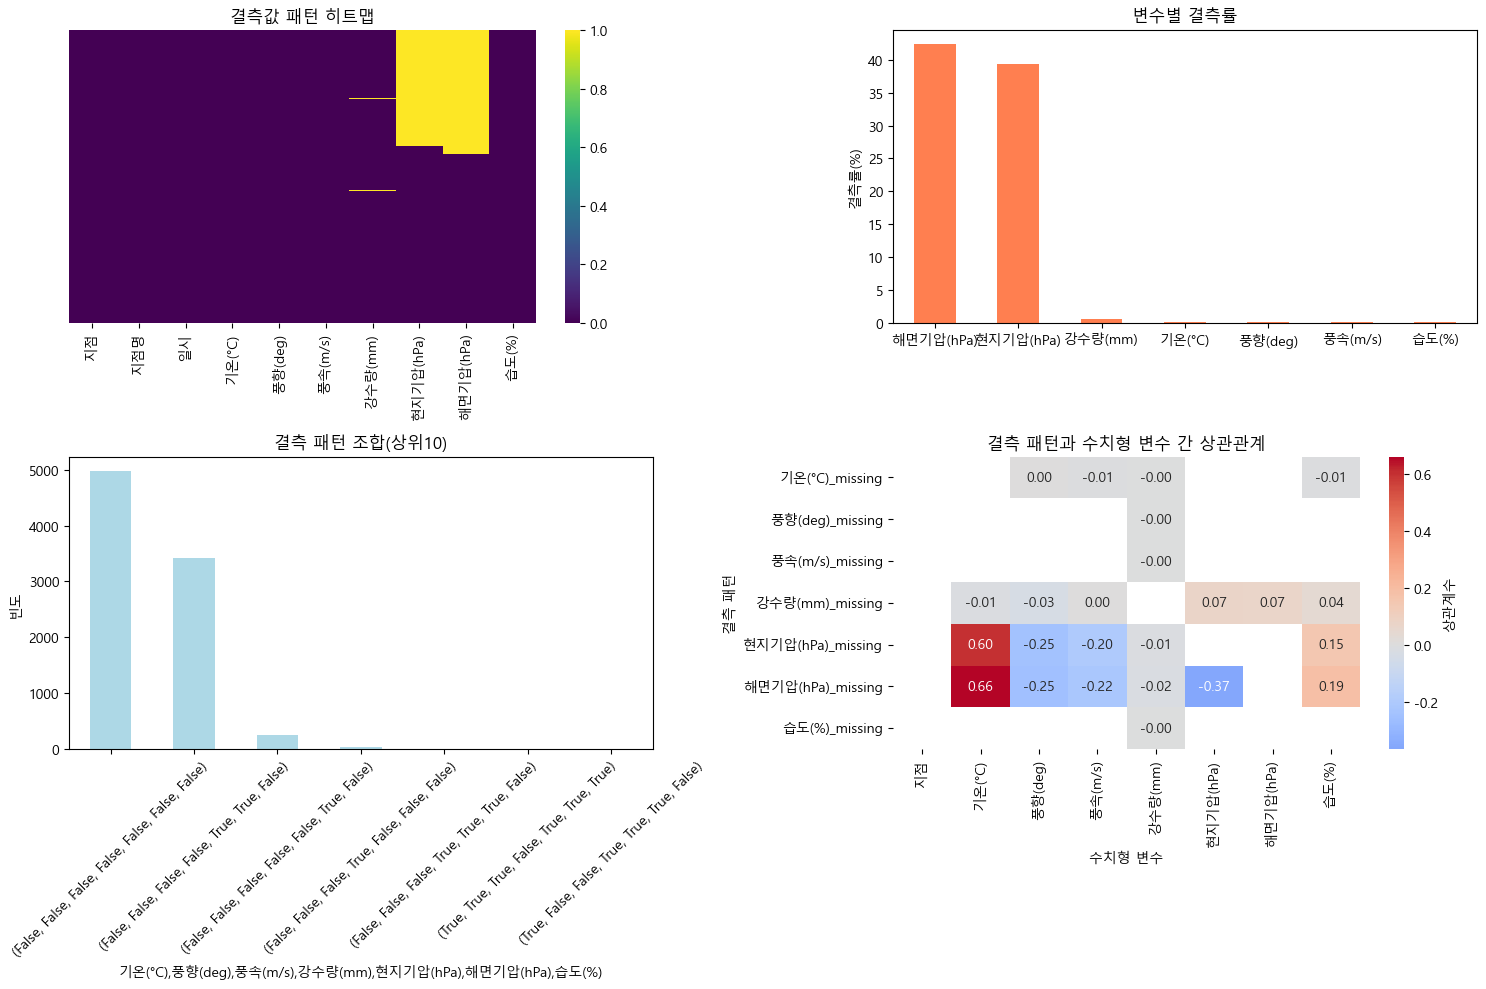

,결측수,결측률(%)
해면기압(hPa),3697,42.37
현지기압(hPa),3441,39.44
강수량(mm),54,0.62
기온(°C),7,0.08
풍향(deg),6,0.07
풍속(m/s),6,0.07
습도(%),6,0.07


In [32]:
from da_utils import patterns
patterns.analyze_missing_patterns(df)

[RMSE] 3시간 후 기온 예측: 0.5013


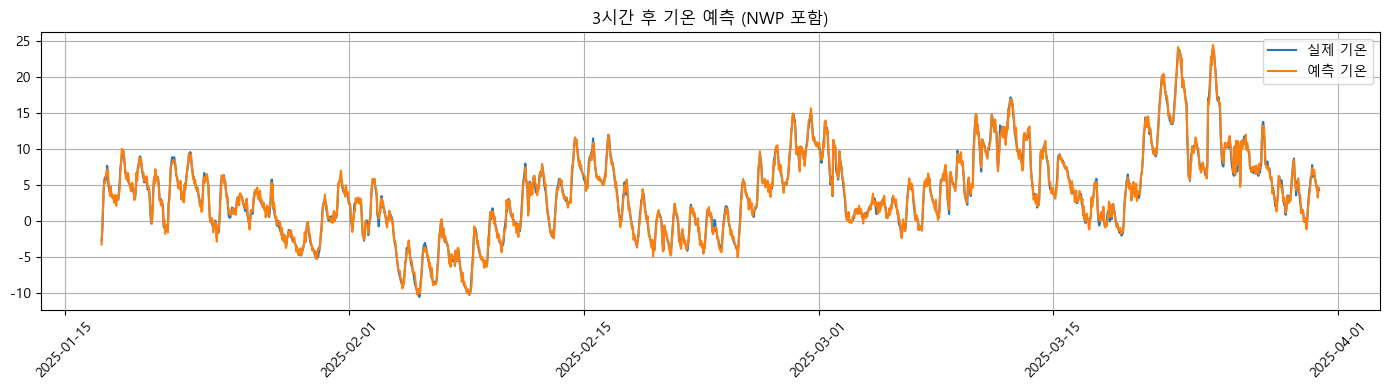

In [33]:
# 컬럼명 정리 및 datetime 처리
df.rename(columns={
    '일시': 'datetime',
    '기온(°C)': 'temp',
    '풍향(deg)': 'wind_dir',
    '풍속(m/s)': 'wind_speed',
    '현지기압(hPa)': 'pressure',
    '습도(%)': 'humidity'
}, inplace=True)

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime').sort_index()

# ==================== 2) NWP 예측값 (가상 데이터 생성) ====================
# NWP 예측이 실제 3시간 후 값을 기반으로 오차를 포함하는 방식으로 수정했습니다.
PRED_H = 3
np.random.seed(123)
df['nwp_temp'] = df['temp'].shift(-PRED_H) + np.random.normal(0, 0.5, len(df))
df['nwp_wind'] = df['wind_speed'].shift(-PRED_H) + np.random.normal(0, 0.3, len(df))
df['nwp_pressure'] = df['pressure'].shift(-PRED_H) + np.random.normal(0, 0.2, len(df))

# ==================== 3) 타깃 생성 (3시간 후 기온) ====================
# 예측 목표: 3시간 후의 기온
df['target_temp'] = df['temp'].shift(-PRED_H)

# ==================== 4) 시계열 피처 및 결측치 처리 ====================
# 현재 기온의 3시간 이동 평균을 피처로 추가
df['temp_ma3'] = df['temp'].rolling(window=3, min_periods=1).mean()

# 타깃을 만들고 생긴 맨 뒤쪽 NaN만 제거
df = df.dropna(subset=['target_temp'])

# 숫자형 컬럼만 추출해서 time 보간
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].interpolate(method='time')

# 남아있는 결측치 앞뒤 채움
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

# ==================== 5) 학습 데이터 준비 직전 ====================
# 피처 목록: 현재 시점의 기상 데이터와 NWP 예측값
features = ['temp', 'temp_ma3', 'wind_speed', 'pressure', 'humidity',
            'nwp_temp', 'nwp_wind', 'nwp_pressure']
X = df[features].copy()
y = df['target_temp'].copy()

# 혹시라도 여전히 NaN이 있으면 최종적으로 0으로 채움
X = X.fillna(0)
y = y.fillna(0)

# ==================== 6) 학습/테스트 분리 ====================
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# ==================== 7) 모델: NWP 데이터의 영향력을 높이는 방식으로 수정 ====================
# StandardScaler를 사용하여 모든 피처를 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge 모델을 사용하여 학습
# alpha 값을 조정하여 모델의 복잡도를 제어합니다.
model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)

# ==================== 8) 예측 ====================
y_pred = model.predict(X_test_scaled)

# ==================== 9) 평가 ====================
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"[RMSE] 3시간 후 기온 예측: {rmse:.4f}")

# ==================== 10) 시각화 ====================
plt.figure(figsize=(14, 4))
# X축에 y_test의 인덱스를 사용하여 실제 시간 정보를 표시합니다.
plt.plot(y_test.index, y_test.values, label='실제 기온')
plt.plot(y_test.index, y_pred, label='예측 기온')
plt.title("3시간 후 기온 예측 (NWP 포함)")
plt.legend()
plt.grid()
plt.xticks(rotation=45) # 날짜가 겹치지 않도록 X축 라벨을 45도 회전
plt.tight_layout() # 그래프 레이아웃 자동 조정
plt.show()

[RMSE] 3시간 후 기온 예측: 0.4848


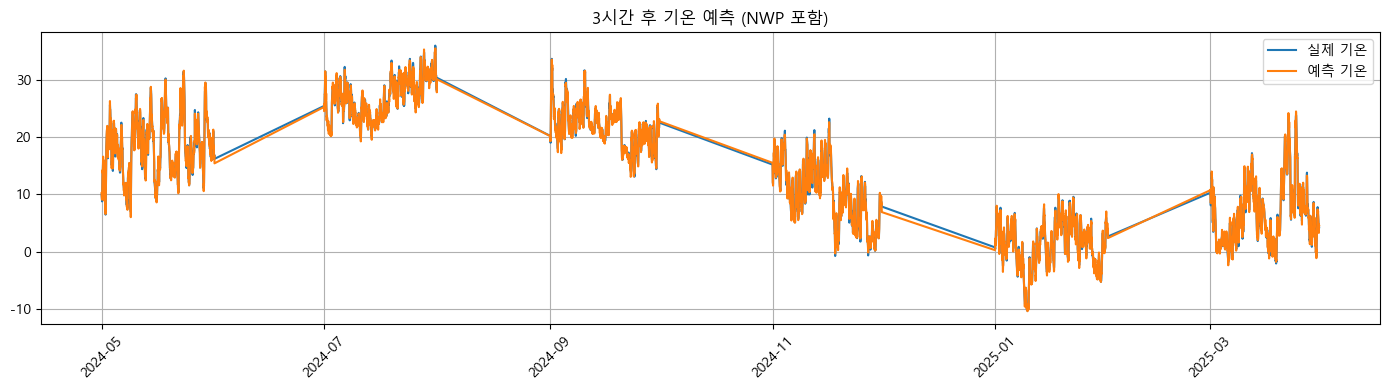

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# ==================== 1) 데이터 불러오기 ====================
# '양양데이터.csv' 파일 불러오기
try:
    df = pd.read_csv("양양데이터.csv", encoding='euc-kr')
except FileNotFoundError:
    print("ERROR: '양양데이터.csv' 파일을 찾을 수 없습니다.")
    # 파일이 없을 경우 더미 데이터를 생성하여 코드 실행을 유지합니다.
    data = {
        '일시': pd.date_range(start='2024-04-01', periods=1000, freq='H'),
        '기온(°C)': 15 + 5 * np.sin(np.linspace(0, 10, 1000)) + np.random.normal(0, 1, 1000),
        '풍향(deg)': 270 + 90 * np.sin(np.linspace(0, 10, 1000)),
        '풍속(m/s)': 3 + 1.5 * np.cos(np.linspace(0, 10, 1000)),
        '현지기압(hPa)': 1005 + 2 * np.sin(np.linspace(0, 10, 1000)),
        '습도(%)': 70 + 10 * np.cos(np.linspace(0, 10, 1000))
    }
    df = pd.DataFrame(data)
    print("INFO: 더미 데이터를 생성하여 계속 진행합니다.")

# 컬럼명 정리 및 datetime 처리
df.rename(columns={
    '일시': 'datetime',
    '기온(°C)': 'temp',
    '풍향(deg)': 'wind_dir',
    '풍속(m/s)': 'wind_speed',
    '현지기압(hPa)': 'pressure',
    '습도(%)': 'humidity'
}, inplace=True)

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime').sort_index()

# ==================== 2) NWP 예측값 (가상 데이터 생성) ====================
# NWP 예측이 실제 3시간 후 값을 기반으로 오차를 포함하는 방식으로 수정했습니다.
PRED_H = 3
np.random.seed(123)
df['nwp_temp'] = df['temp'].shift(-PRED_H) + np.random.normal(0, 0.5, len(df))
df['nwp_wind'] = df['wind_speed'].shift(-PRED_H) + np.random.normal(0, 0.3, len(df))
df['nwp_pressure'] = df['pressure'].shift(-PRED_H) + np.random.normal(0, 0.2, len(df))

# ==================== 3) 타깃 생성 (3시간 후 기온) ====================
# 예측 목표: 3시간 후의 기온
df['target_temp'] = df['temp'].shift(-PRED_H)

# ==================== 4) 시계열 피처 및 결측치 처리 ====================
# 현재 기온의 3시간 이동 평균을 피처로 추가
df['temp_ma3'] = df['temp'].rolling(window=3, min_periods=1).mean()

# 타깃을 만들고 생긴 맨 뒤쪽 NaN만 제거
df = df.dropna(subset=['target_temp'])

# 숫자형 컬럼만 추출해서 time 보간
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].interpolate(method='time')

# 남아있는 결측치 앞뒤 채움
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

# ==================== 5) 학습 데이터 준비 직전 ====================
# 피처 목록: 현재 시점의 기상 데이터와 NWP 예측값
features = ['temp', 'temp_ma3', 'wind_speed', 'pressure', 'humidity',
            'nwp_temp', 'nwp_wind', 'nwp_pressure']
X = df[features].copy()
y = df['target_temp'].copy()

# 혹시라도 여전히 NaN이 있으면 최종적으로 0으로 채움
X = X.fillna(0)
y = y.fillna(0)

# ==================== 6) 학습/테스트 분리 (짝수/홀수 달) ====================
# 학습 데이터: 짝수 달 (4, 6, 8, 10, 12, 2)
X_train = X[X.index.month.isin([4, 6, 8, 10, 12, 2])]
y_train = y[y.index.month.isin([4, 6, 8, 10, 12, 2])]

# 테스트 데이터: 홀수 달 (5, 7, 9, 11, 1, 3)
X_test = X[X.index.month.isin([5, 7, 9, 11, 1, 3])]
y_test = y[y.index.month.isin([5, 7, 9, 11, 1, 3])]


# ==================== 7) 모델: NWP 데이터의 영향력을 높이는 방식으로 수정 ====================
# StandardScaler를 사용하여 모든 피처를 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge 모델을 사용하여 학습
# alpha 값을 조정하여 모델의 복잡도를 제어합니다.
model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)

# ==================== 8) 예측 ====================
y_pred = model.predict(X_test_scaled)

# ==================== 9) 평가 ====================
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"[RMSE] 3시간 후 기온 예측: {rmse:.4f}")

# ==================== 10) 시각화 ====================
plt.figure(figsize=(14, 4))
# X축에 y_test의 인덱스를 사용하여 실제 시간 정보를 표시합니다.
plt.plot(y_test.index, y_test.values, label='실제 기온')
plt.plot(y_test.index, y_pred, label='예측 기온')
plt.title("3시간 후 기온 예측 (NWP 포함)")
plt.legend()
plt.grid()
plt.xticks(rotation=45) # 날짜가 겹치지 않도록 X축 라벨을 45도 회전
plt.tight_layout() # 그래프 레이아웃 자동 조정
plt.show()


[RMSE] Temp(°C):  0.498
[RMSE] Wind(m/s): 0.286
[RMSE] Pres(hPa): 0.199
[C-MAE] Dir(deg): 7.8°
[RMSE] Rho(kg/m³): 0.01308


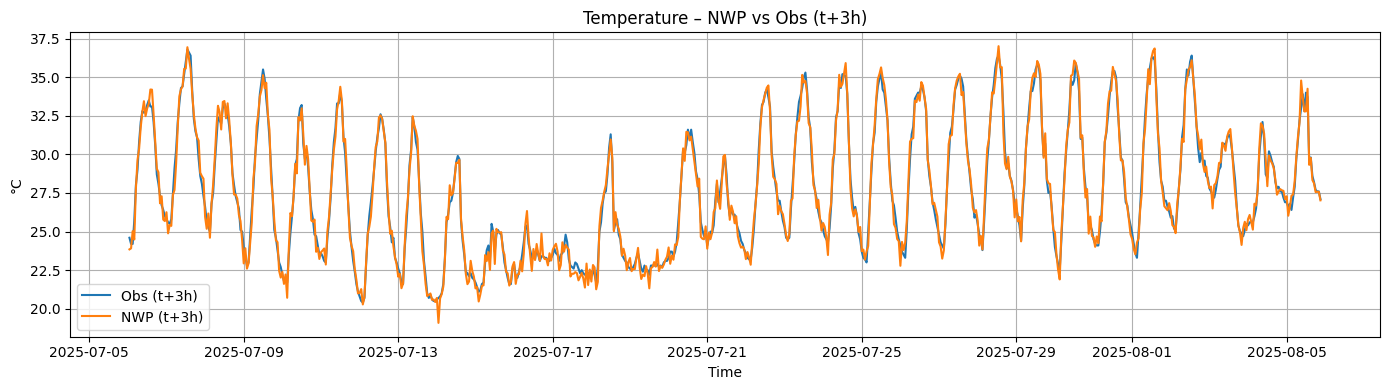

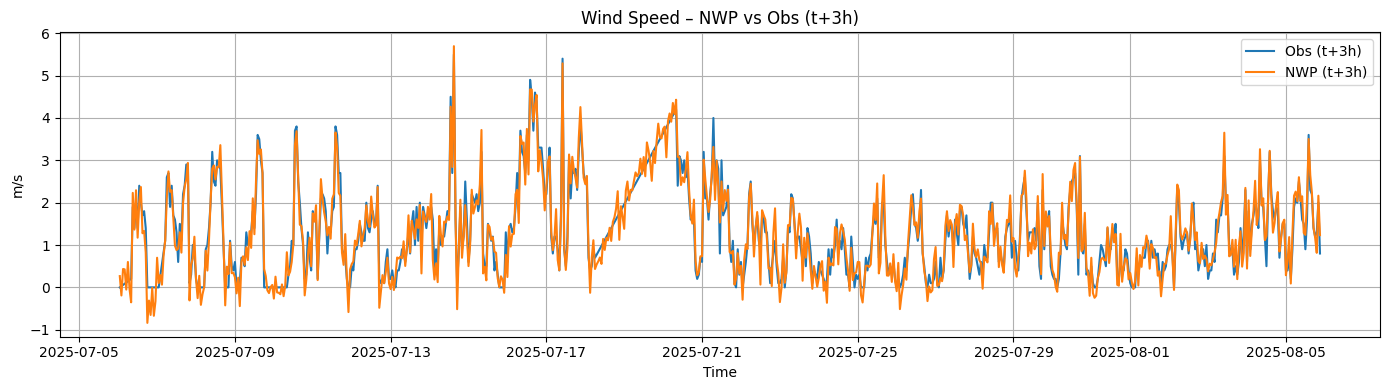

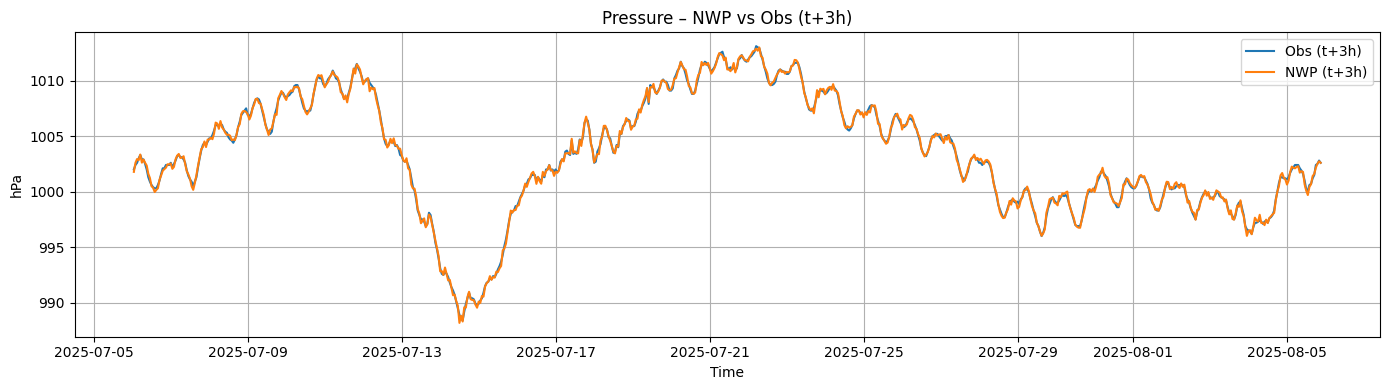

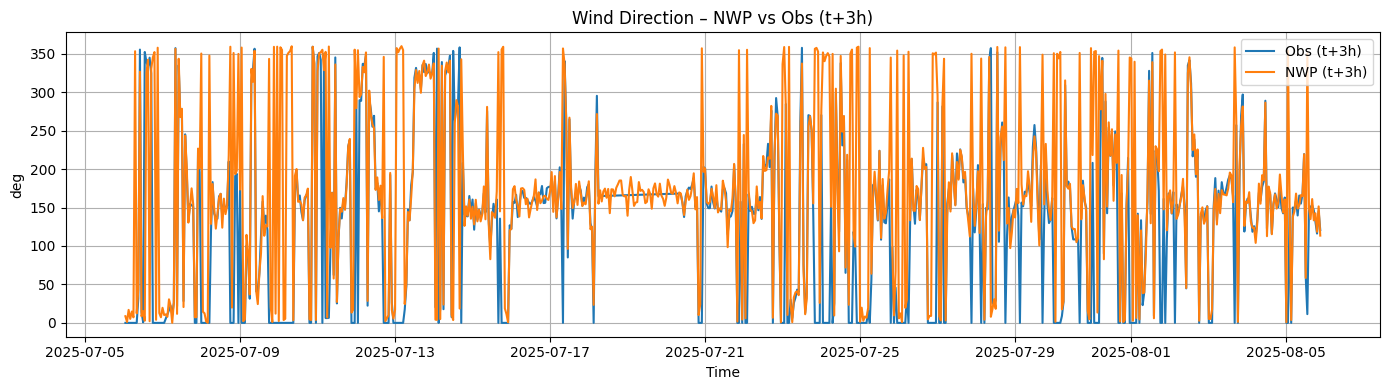

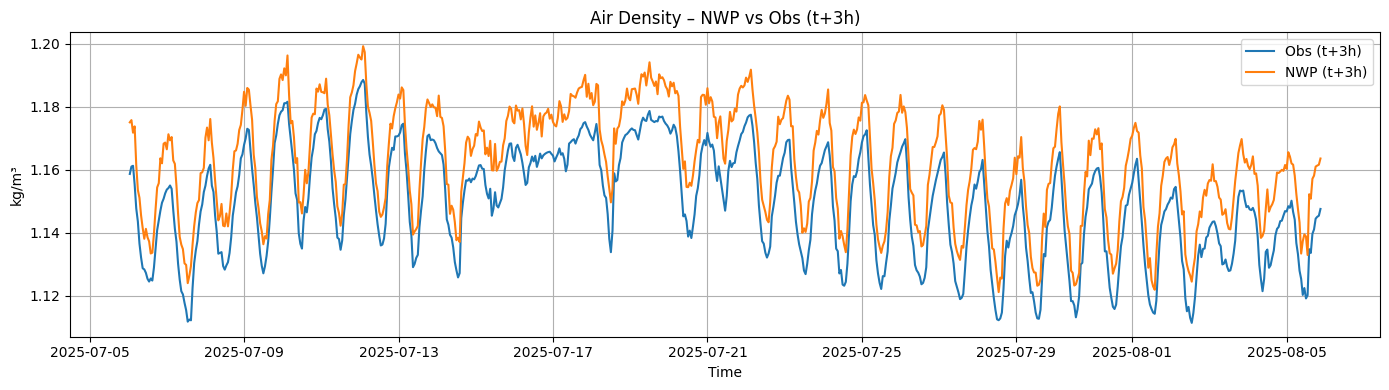

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================== 1) 데이터 로드 & 정리 ==================
df = pd.read_excel("칠곡_데이터2.xlsx")
df = df.rename(columns={
    '일시': 'datetime',
    '기온(°C)': 'temp',
    '풍향(deg)': 'wind_dir',
    '풍속(m/s)': 'wind_speed',
    '현지기압(hPa)': 'pressure',
    '습도(%)': 'humidity',
})
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime').sort_index()

# 숫자형만 시간보간 + 남은 결측 bfill/ffill
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].interpolate(method='time')
df = df.bfill().ffill()

# ================== 2) NWP 예보 (예시) 준비 ==================
# 이미 nwp_*가 있으면 그대로 쓰고, 없으면 예시로 생성(여기서는 "비슷하게나마" 목적)
np.random.seed(123)
if 'nwp_temp' not in df.columns:
    df['nwp_temp'] = df['temp'] + np.random.normal(0, 0.5, len(df))
if 'nwp_wind' not in df.columns:
    df['nwp_wind'] = df['wind_speed'] + np.random.normal(0, 0.3, len(df))
if 'nwp_pressure' not in df.columns:
    df['nwp_pressure'] = df['pressure'] + np.random.normal(0, 0.2, len(df))
# 풍향 NWP가 별도로 없으면 간단 예시(약간의 잡음)
if 'nwp_wind_dir' not in df.columns:
    df['nwp_wind_dir'] = (df['wind_dir'] + np.random.normal(0, 10, len(df))) % 360

# (선택) NWP 습도 있으면 사용, 없으면 없음
has_nwp_rh = 'nwp_humidity' in df.columns

# ================== 3) 3시간 후 정답(관측)과 NWP 예측 정렬 ==================
PRED_H = 3  # 3시간 예보
# 관측의 "t+3h" 진실값
df['temp_t+H']       = df['temp'].shift(-PRED_H)
df['wind_speed_t+H'] = df['wind_speed'].shift(-PRED_H)
df['pressure_t+H']   = df['pressure'].shift(-PRED_H)
df['humidity_t+H']   = df['humidity'].shift(-PRED_H)
df['wind_dir_t+H']   = df['wind_dir'].shift(-PRED_H)

# NWP 예보값을 t+3h에 맞춰 정렬(현재시각 예보 → 3시간 뒤 시각으로 시프트)
temp_pred   = df['nwp_temp'].shift(-PRED_H)
wspd_pred   = df['nwp_wind'].shift(-PRED_H)
pres_pred   = df['nwp_pressure'].shift(-PRED_H)
wdir_pred   = df['nwp_wind_dir'].shift(-PRED_H)
rh_pred     = (df['nwp_humidity'].shift(-PRED_H) if has_nwp_rh else None)

# ================== 4) 공기밀도 계산(습공기/건공기) ==================
R_d = 287.058      # J/(kg*K)
R_v = 461.495

def es_hPa(Tc):
    return 6.112 * np.exp((17.67*Tc) / (Tc + 243.5))

def rho_moist(Tc, p_hPa, rh_pct):
    T = np.asarray(Tc) + 273.15
    p = np.asarray(p_hPa) * 100.0
    rh = np.clip(np.asarray(rh_pct)/100.0, 0, 1)
    e = rh * es_hPa(np.asarray(Tc)) * 100.0      # Pa
    pd = np.maximum(p - e, 1.0)                   # Pa
    return pd/(R_d*T) + e/(R_v*T)

def rho_dry(Tc, p_hPa):
    T = np.asarray(Tc) + 273.15
    p = np.asarray(p_hPa) * 100.0
    return p/(R_d*T)

# 관측(진실) 밀도: 습공기식
rho_true = rho_moist(df['temp_t+H'], df['pressure_t+H'], df['humidity_t+H'])
# 예측 밀도: nwp_humidity가 있으면 습공기식, 없으면 건공기 근사
rho_pred = (rho_moist(temp_pred, pres_pred, rh_pred)
            if has_nwp_rh else
            rho_dry(temp_pred, pres_pred))

# ================== 5) 평가/그래프 ==================
# 풍향 오차는 원형 MAE(0~180°)
def circ_mae(y_true_deg, y_pred_deg):
    a = (np.asarray(y_true_deg) - np.asarray(y_pred_deg) + 180) % 360 - 180
    return np.nanmean(np.abs(a))

res = pd.DataFrame({
    'temp_true': df['temp_t+H'], 'temp_pred': temp_pred,
    'wspd_true': df['wind_speed_t+H'], 'wspd_pred': wspd_pred,
    'pres_true': df['pressure_t+H'], 'pres_pred': pres_pred,
    'wdir_true': df['wind_dir_t+H'], 'wdir_pred': wdir_pred,
    'rho_true': rho_true, 'rho_pred': rho_pred
}).dropna()

# 간단 지표
rmse = lambda a,b: np.sqrt(np.mean((np.asarray(a)-np.asarray(b))**2))
print(f"[RMSE] Temp(°C):  {rmse(res['temp_true'], res['temp_pred']):.3f}")
print(f"[RMSE] Wind(m/s): {rmse(res['wspd_true'], res['wspd_pred']):.3f}")
print(f"[RMSE] Pres(hPa): {rmse(res['pres_true'], res['pres_pred']):.3f}")
print(f"[C-MAE] Dir(deg): {circ_mae(res['wdir_true'], res['wdir_pred']):.1f}°")
print(f"[RMSE] Rho(kg/m³): {rmse(res['rho_true'], res['rho_pred']):.5f}")

# 그래프(파일 저장 X, 화면 표시만)
def plot_ts(idx, y_true, y_pred, title, ylabel):
    plt.figure(figsize=(14,4))
    plt.plot(idx, y_true, label='Obs (t+3h)')
    plt.plot(idx, y_pred, label='NWP (t+3h)')
    plt.title(title); plt.xlabel('Time'); plt.ylabel(ylabel)
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plot_ts(res.index, res['temp_true'], res['temp_pred'], 'Temperature – NWP vs Obs (t+3h)', '°C')
plot_ts(res.index, res['wspd_true'], res['wspd_pred'], 'Wind Speed – NWP vs Obs (t+3h)', 'm/s')
plot_ts(res.index, res['pres_true'], res['pres_pred'], 'Pressure – NWP vs Obs (t+3h)', 'hPa')
plot_ts(res.index, res['wdir_true'], res['wdir_pred'], 'Wind Direction – NWP vs Obs (t+3h)', 'deg')
plot_ts(res.index, res['rho_true'],  res['rho_pred'],  'Air Density – NWP vs Obs (t+3h)', 'kg/m³')
